## Collect Data

In [1]:
!wget -q --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
!wget -q --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-RecognitionTask.zip

In [2]:
%%capture
!unrar e UCF101.rar data/
!unzip -qq UCF101TrainTestSplits-RecognitionTask.zip

## Imports

In [3]:
from imutils import paths
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import cv2
import os

## Metadata Loading

In [4]:
# Open the .txt file which have names of training videos
f = open("ucfTrainTestlist/trainlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# Create a dataframe having video names
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]
train.head()

,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi 1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi 1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi 1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi 1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi 1


In [5]:
# Open the .txt file which have names of test videos
with open("ucfTrainTestlist/testlist01.txt", "r") as f:
    temp = f.read()
videos = temp.split("\n")

# Create a dataframe having video names
test = pd.DataFrame()
test["video_name"] = videos
test = test[:-1]
test.head()

,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi


## Utility Functions

In [6]:
def extract_tag(video_path):
    return video_path.split("/")[0]

def separate_video_name(video_name):
    return video_name.split("/")[1]

def rectify_video_name(video_name):
    return video_name.split(" ")[0]

def move_videos(df, output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    for i in tqdm(range(df.shape[0])):
        videoFile = df['video_name'][i].split("/")[-1]
        videoPath = os.path.join("data", videoFile)
        shutil.copy2(videoPath, output_dir)
    print()
    print(f"Total videos: {len(os.listdir(output_dir))}")

## DataFrame Preparation

In [7]:
train["tag"] = train["video_name"].apply(extract_tag)
train["video_name"] = train["video_name"].apply(separate_video_name)
train.head()

,video_name,tag
0,v_ApplyEyeMakeup_g08_c01.avi 1,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g08_c02.avi 1,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g08_c03.avi 1,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g08_c04.avi 1,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g08_c05.avi 1,ApplyEyeMakeup


In [8]:
train["video_name"] = train["video_name"].apply(rectify_video_name)
train.head()

,video_name,tag
0,v_ApplyEyeMakeup_g08_c01.avi,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g08_c02.avi,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g08_c03.avi,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g08_c04.avi,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g08_c05.avi,ApplyEyeMakeup


In [9]:
test["tag"] = test["video_name"].apply(extract_tag)
test["video_name"] = test["video_name"].apply(separate_video_name)
test.head()

,video_name,tag
0,v_ApplyEyeMakeup_g01_c01.avi,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g01_c02.avi,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g01_c03.avi,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g01_c04.avi,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g01_c05.avi,ApplyEyeMakeup


## Filtering Top-n Actions

In [10]:
classes_to_keep = ["RockClimbingIndoor", "RopeClimbing", "WallPushups", "Punch", "Fencing"]

train_new = train[train["tag"].isin(classes_to_keep)]
test_new = test[test["tag"].isin(classes_to_keep)]

train_new.shape, test_new.shape


((481, 2), (183, 2))

In [ ]:
n = 10
topNActs = train["tag"].value_counts().nlargest(n).reset_index()["index"].tolist()
train_new = train[train["tag"].isin(topNActs)]
test_new = test[test["tag"].isin(topNActs)]
train_new.shape, test_new.shape

((1171, 2), (459, 2))

In [11]:
train_new = train_new.reset_index(drop=True)
test_new = test_new.reset_index(drop=True)

## Move Top-n Action Videos

In [12]:
move_videos(train_new, "train")
move_videos(test_new, "test")

100%|██████████| 481/481 [00:03<00:00, 130.09it/s]



Total videos: 481


100%|██████████| 183/183 [00:00<00:00, 312.22it/s]


Total videos: 183


In [13]:
train_new.to_csv("train.csv", index=False)
test_new.to_csv("test.csv", index=False)

## Serialization

In [ ]:
!tar cf ucf101_top10.tar.gz train test train.csv test.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp ucf101_top10.tar.gz /content/drive/MyDrive

In [14]:
import os

import keras
from imutils import paths

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from IPython.display import Image

In [15]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [16]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 481
Total videos for testing: 183


,video_name,tag
178,v_Punch_g23_c02.avi,Punch
221,v_RockClimbingIndoor_g12_c02.avi,RockClimbingIndoor
69,v_Fencing_g24_c01.avi,Fencing
467,v_WallPushups_g22_c04.avi,WallPushups
252,v_RockClimbingIndoor_g17_c07.avi,RockClimbingIndoor
54,v_Fencing_g20_c02.avi,Fencing
146,v_Punch_g18_c02.avi,Punch
390,v_WallPushups_g08_c05.avi,WallPushups
245,v_RockClimbingIndoor_g16_c05.avi,RockClimbingIndoor
426,v_WallPushups_g15_c05.avi,WallPushups


In [17]:
# Define a mapping for tag names to be renamed
tag_mapping = {"RockClimbingIndoor": "WallClimbing", "WallPushups": "WallContact"}

# Replace tag names in the "tag" column
train_df["tag"].replace(tag_mapping, inplace=True)
test_df["tag"].replace(tag_mapping, inplace=True)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 481
Total videos for testing: 183


,video_name,tag
407,v_WallPushups_g12_c01.avi,WallContact
183,v_Punch_g23_c07.avi,Punch
116,v_Punch_g13_c06.avi,Punch
173,v_Punch_g22_c04.avi,Punch
421,v_WallPushups_g14_c05.avi,WallContact
304,v_RopeClimbing_g08_c04.avi,RopeClimbing
93,v_Punch_g10_c03.avi,Punch
86,v_Punch_g09_c03.avi,Punch
378,v_RopeClimbing_g24_c02.avi,RopeClimbing
122,v_Punch_g14_c05.avi,Punch


In [18]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [19]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 4s 0us/step


In [20]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['Fencing', 'Punch', 'RopeClimbing', 'WallClimbing', 'WallContact']


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

In [23]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None])

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (481, 20, 2048)
Frame masks in train set: (481, 20)


In [25]:
EPOCHS = 40

In [26]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/40
10/11 [==========================>...] - ETA: 0s - loss: 1.5760 - accuracy: 0.2344
Epoch 1: val_loss improved from inf to 1.63967, saving model to /tmp/video_classifier/ckpt.weights.h5
11/11 [==============================] - 13s 341ms/step - loss: 1.5715 - accuracy: 0.2500 - val_loss: 1.6397 - val_accuracy: 0.1448
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 1.4318 - accuracy: 0.4048
Epoch 2: val_loss improved from 1.63967 to 1.59114, saving model to /tmp/video_classifier/ckpt.weights.h5
11/11 [==============================] - 1s 61ms/step - loss: 1.4318 - accuracy: 0.4048 - val_loss: 1.5911 - val_accuracy: 0.1310
Epoch 3/40
10/11 [==========================>...] - ETA: 0s - loss: 1.2920 - accuracy: 0.5594
Epoch 3: val_loss did not improve from 1.59114
11/11 [==============================] - 1s 58ms/step - loss: 1.2925 - accuracy: 0.5536 - val_loss: 1.5921 - val_accuracy: 0.1310
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 1.1

In [ ]:
model_save_path = "/content/drive/MyDrive/Video_Class.h5"
sequence_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

In [30]:
sequence_model = keras.models.load_model(model_save_path)

Test video path: v_RockClimbingIndoor_g01_c05.avi
1/1 [==============================] - 0s 26ms/step
  WallClimbing: 29.08%
  WallContact: 20.47%
  Punch: 19.25%
  RopeClimbing: 19.02%
  Fencing: 12.18%


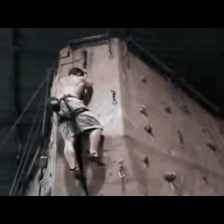

In [35]:
#Inference
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])